In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN

# Домашняя работа 5

Поработаем с датасетом о [пользователях кредитных карт](https://www.kaggle.com/arjunbhasin2013/ccdata). 

Мы хотим кластеризовать пользователей на категории для того, чтобы по-разному настраивать рекламу на них.

In [7]:
df = pd.read_csv('../data/CC GENERAL.csv')
df = df.drop('CUST_ID', axis=1)
df.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [8]:
print(df.isnull().sum(), '\n\n Num of lines', df.shape[0])

BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64 

 Num of lines 8950


In [9]:
df = df.dropna() # количество нулевых строк незначительно, поэтому просто удалим их

## Easy

Выдвинуть гипотезу по каким признакам нужно кластеризовать пользователей. Провести кластеризацию одним любым методом, проанализировать "на глаз" насколько хорошо получилось, можно ли как-то проинтерпретировать кластеры?

Будем производить кластеризацию по всем признакам, которые более-менее не дискретны (иначе результат кластеризации очень предсказуем и выполнить данное деление можно алгоритмически; более того, очевидно, что такое деление не будет полезным, ибо ни один из параметров не является определяющим для того или иного предложения).

In [10]:
df_clast = df[['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS']]

In [11]:
model = KMeans(n_clusters=3)
model_labels = model.fit_predict(df_clast)

In [23]:
embedding = TSNE()
embedding_data = embedding.fit_transform(df_clast)

<Axes: >

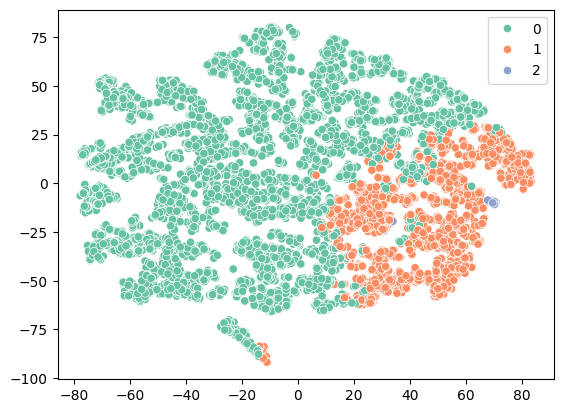

In [24]:
sns.scatterplot(x=embedding_data[:, 0], y=embedding_data[:, 1], hue=model_labels, palette=sns.color_palette('Set2', 3))

На самом деле результат очень предсказуем, ибо либо данные сильно связаны, либо практически независимы. Из-за этого ккластеров как таковых не существует, поэтому модель (и последующие модели) работает хреново.

## Normal

Провести кластеризацию несколькими методами. Объяснить какой результат лучше и почему. Проинтерпретировать кластеры в лучшем разбиении.

In [44]:
def claster_info(clear_model):
    model_labels = clear_model.fit_predict(df_clast)

    sns.scatterplot(x=embedding_data[:, 0], y=embedding_data[:, 1], hue=model_labels, palette=sns.color_palette('Set2', 3))

C:\Users\setday\AppData\Local\Temp\ipykernel_73484\661420219.py:4: UserWarning: 
The palette list has fewer values (3) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(x=embedding_data[:, 0], y=embedding_data[:, 1], hue=model_labels, palette=sns.color_palette('Set2', 3))


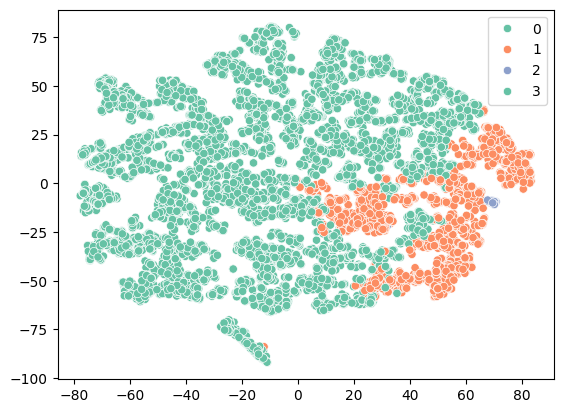

In [64]:
claster_info(AgglomerativeClustering(n_clusters=3)) # при n больших 3 кластеры получаются слишком маленькими

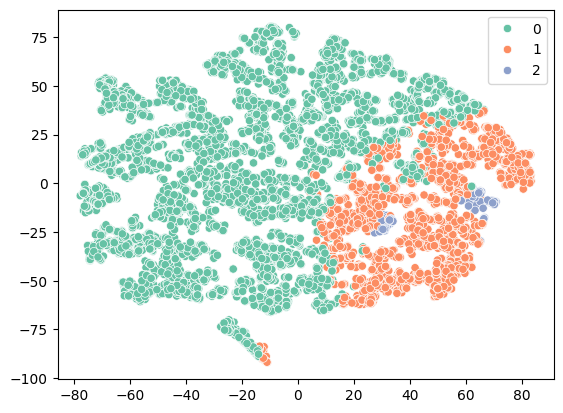

In [46]:
claster_info(KMeans(n_clusters=3))

C:\Users\setday\AppData\Local\Temp\ipykernel_73484\661420219.py:4: UserWarning: 
The palette list has fewer values (3) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(x=embedding_data[:, 0], y=embedding_data[:, 1], hue=model_labels, palette=sns.color_palette('Set2', 3))


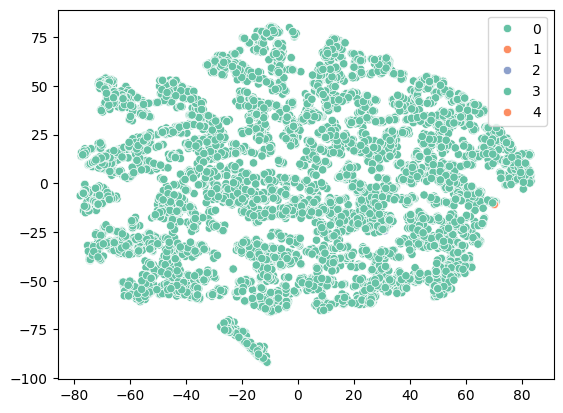

In [63]:
claster_info(DBSCAN(eps=20000, min_samples=1)) # работает очень плохо, при малых eps и при больших: кластеры всегда слишком мелкие

На самом деле, при делении на 2 кластера, `KMeans` и `AgglomerativeClustering` дадут два более-менее адекватных кластера.

## Hard

Построить модель, которая будет предсказывать, насколько обеспеченный пользователь. Добавить в такую модель кластеризацию/метод понижения размерности и проверить, можно ли улучшить качество (или хотя бы не потерять), уменьшив при этом размер датасета?

Важно: в этой задаче нужно определить, что такое "обеспеченный пользователь" и не переобучиться (сделать так, чтобы в train и test были действительно разные данные, которые никак друг с другом не связаны)

## Полезные ссылки

- [Цикл статей о алгоритмах кластеризации](https://habr.com/ru/post/321216/)
- [Про нечеткую кластеризацию](https://en.wikipedia.org/wiki/Fuzzy_clustering)
- [Подробнее про метод главных компонент](https://habr.com/ru/post/304214/)
- [Как подобрать платье с помощью метода главных компонент](https://habr.com/ru/company/io/blog/265089/)